**Defining Agent Types**

Daisy has three values aside from id and pos: age, breed (`:black` or `:white`), and albedo set by user. 
Land represents the surface, with the additional value of Temperature. Since the entire surface has the same albedo field, we don't need to set it as a Land value. 

*Note: Land does not necessarily have to be an agent, and you can represent surface temperature as a matrix (model parameter). This gives a performance advantage,*
*but incorporating surface agents allows for easier visualization*

In [1]:
using Agents, Plots 
using Statistics: mean

mutable struct Daisy <: AbstractAgent
    id::Int
    pos::Dims{2}
    breed::Symbol
    age::Int
    albedo::Float64 #0-1 Fraction
end


const DaisyWorld = ABM{<:GridSpace, Daisy};

**World Heating**

Surface temperature of the world is heated by the sun, but the daisies growing on the surface will either reflect or absorb the sunlight, altering the surface temperature

In [2]:
function update_surface_temperature!(pos, model::DaisyWorld)
    ids = ids_in_position(pos, model)
    absorbed_luminosity = if isempty(ids) #no daisy
        #Set luminosity vias surface albedo
        (1-model.surface_albedo)*model.solar_luminosity 
    else
        #Set luminosity vis daisy albedo
        (1-model[ids[1]].albedo) * model.solar_luminosity
    end
    #We expect heating to be 80 °C for an absorbed luminosity of 1,
    #approximately 30 for 0.5 and approximately -273 for 0.01.
    local_heating = (absorbed_luminosity > 0) ? 72 * log(absorbed_luminosity) + 80 : 80
    #Surface temperature is the average of the current temperature and local heating
    model.temperature[pos...] = (model.temperature[pos...] + local_heating) / 2
end


update_surface_temperature! (generic function with 1 method)

Additionally, temperature diffuses over time.

In [3]:
function diffuse_temperature!(pos, model::DaisyWorld)
    ratio = get(model.properties, :ratio, 0.5) #diffusion ratio
    npos = nearby_positions(pos, model)
    model.temperature[pos...] = 
        (1 - ratio) * model.temperature[pos...] +
        #each neighbor is giving up 1/8 of the diffused
        #amount to each of *its* neighbors
        sum(model.temperature[p...] for p in npos) * 0.125 * ratio
end


diffuse_temperature! (generic function with 1 method)

**Daisy Dynamics**

Function below determines the optimal temperature for growth. If temperature is too hot or too cold, Daisies will not wish to propagate. As long as temperature is optimal, Daisies will compete for land and create new Daisies of their `breed` close to them. 

In [4]:
function propagate!(pos, model::DaisyWorld)
    ids = ids_in_position(pos, model)
    if !isempty(ids)
        daisy = model[ids[1]]
        temperature = model.temperature[pos...]
        # Set optimum growth rate to 22.5 °C, with bounds of [5, 40]
        seed_threshold = (0.1457 * temperature - 0.0032 * temperature^2) - 0.6443
        if rand(model.rng) < seed_threshold
            #Collect all adjacent positions that have no daisies
            empty_neighbors = Tuple{Int, Int}[]
            neighbors = nearby_positions(pos, model)
            for n in neighbors
                if isempty(ids_in_position(n,model))
                    push!(empty_neighbors, n)
                end
            end
            if !isempty(empty_neighbors)
                #Seed a new daisy in one of those position
                seeding_place = rand(model.rng, empty_neighbors)
                add_agent!(seeding_place, model, daisy.breed, 0, daisy.albedo) 
            end
        end
    end
end



propagate! (generic function with 1 method)

If Daisies cross the age threshold, they die out. Death is controlled by the `agent_step` function

In [5]:
function agent_step!(agent::Daisy, model::DaisyWorld)
    agent.age += 1
    agent.age ≥ model.max_age && kill_agent!(agent, model)
end


agent_step! (generic function with 1 method)

`model_step` function advances the Daisyworld model dynamics. If We have defined a number of helper functions above, so this function is only matter of calling these helper functions. 

In [6]:
function model_step!(model)
    for p in positions(model)
        update_surface_temperature!(p, model)
        diffuse_temperature!(p, model)
        propagate!(p, model)
    end
    model.tick += 1
    solar_activity!(model)
end


model_step! (generic function with 1 method)

`solar_activity` function changes the amount of incoming solar radiation over time (if the "scenario" parameter is `:ramp`). Model parameter tick keeps track of time

In [7]:
function solar_activity!(model::DaisyWorld)
    if model.scenario == :ramp
        if model.tick > 200 && model.tick ≤ 400
            model.solar_luminosity += model.solar_change
        end
        if model.tick > 500 && model.tick ≤ 750
            model.solar_luminosity -= model.solar_change / 2
        end
    elseif model.scenario == :change
        model.solar_luminosity += model.solar_change
    end
end

solar_activity! (generic function with 1 method)

**Initialising Daisyworld**

Here, we construct a function to initialize Daisyworld. First, we use `fill_space!` to fill grid spaces with `Land` agents. Next, we seed planet with daisies of each type and define their albedos. 

In [9]:
import StatsBase
using Random

function daisyworld(;
    griddims = (30,30),
    max_age = 25,
    init_white = 0.2, # %cover of the world surface of white breed
    init_black = 0.2, # %cover of world surface of black breed
    albedo_white = 0.75,
    albedo_black = 0.25,
    surface_albedo = 0.4,
    solar_change = 0.005,
    solar_luminosity = 1.0, #initial solar_luminosity
    scenario = :default,
    seed = 165,
)
    rng = MersenneTwister(seed)
    space = GridSpace(griddims)
    properties = Dict(:max_age => max_age, :surface_albedo => surface_albedo, :solar_luminosity => solar_luminosity, :solar_change => solar_change, :scenario => scenario)
    properties[:tick] = 0
    properties[:temperature] = zeros(griddims)

    model = ABM(
        Daisy,
        space;
        properties = properties,
        rng,
        warn = false,
    )


    #Populate with daisies: each position has only one daisy (black or white)
    grid = collect(positions(model))
    num_positions = prod(griddims) #product of dimmensions. Finds area of grid
    white_positions = 
        StatsBase.sample(grid, Int(init_white * num_positions); replace = false)
    for wp in white_positions
        wd = Daisy(nextid(model), wp, :white, rand(model.rng, 0:max_age),albedo_white)
        add_agent_pos!(wd, model)
    end
    allowed = setdiff(grid, white_positions)
    black_positions = 
        StatsBase.sample(allowed, Int(init_black * num_positions); replace = false)
    for bp in black_positions
        wd = Daisy(nextid(model), bp, :black, rand(model.rng, 0:max_age), albedo_black)
        add_agent_pos!(wd, model)
    end
    
    #adjust temperature to initial daisy distribution
    for p in positions(model)
        update_surface_temperature!(p, model)
    end

    return model
end


daisyworld (generic function with 1 method)

**Visualizing & Animating**


In [10]:
using InteractiveDynamics
using GLMakie
#using CairoMakie
#CairoMakie.activate!()

model = daisyworld()

AgentBasedModel with 360 agents of type Daisy
 space: GridSpace with size (30, 30), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: temperature, solar_luminosity, max_age, surface_albedo, solar_change, tick, scenario

Visualize using `abmplot`. Also utilize the ability to plot an underlying heatmap, whil will be the model surface temperature. 

See `InteractiveDynamics.abmplot` Function API for keywoard explanation and arguments

In [11]:
daisycolor(a::Daisy) = a.breed

plotkwargs = (
    ac = daisycolor, as = 20, am = '✿',
    scatterkwargs = (strokewidth = 1.0,),
    heatarray = :temperature,
    heatkwargs = (colorrange = (-20,60),colormap = :thermal),
)
fig, ax, abmobs = abmplot(model;plotkwargs...)
fig

Figure()

**Interactive ABM Applications**

Continuing from the Daisyworld plots above, we can turn them into interactive applications straightforwardly, simply by providing the stepping functions as illustrated in the documentation of abmplot. 

*Note that `GLMakie` should be used instead of `CairoMakie` when wanting to use the interactive aspects of the plots.*

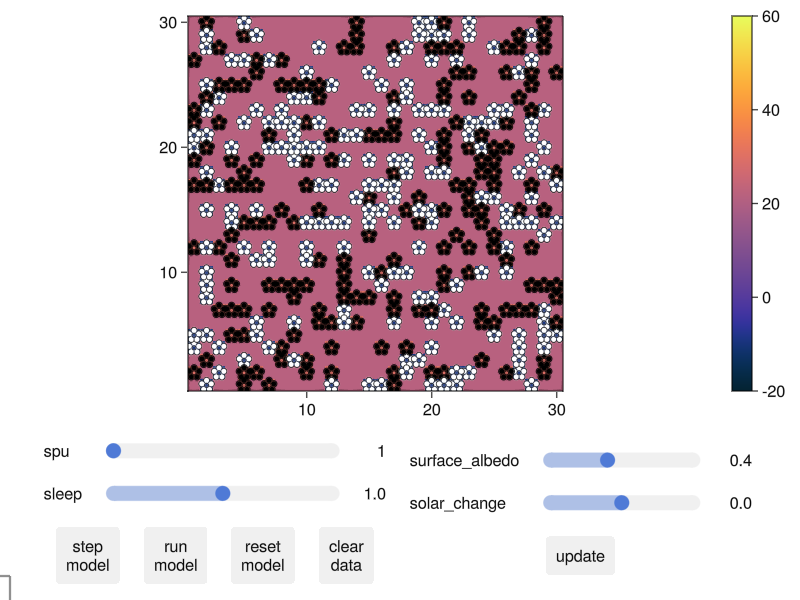

In [12]:
using GLMakie

params = Dict(
    :surface_albedo => 0:0.01:1,
    :solar_change => -0.1:0.01:0.1,
)
fig, ax, abmobs = abmplot(model;
agent_step!, model_step!, params, plotkwargs...)

fig

**Evolution Related**

agent_step!, model_step! = Agents.dummystep: Stepping functions to pass to ABMObservable which itself passes to Agents.step!.

add_controls::Bool: If true, abmplot switches to "interactive application" mode. This is by default true if either agent_step! or model_step! keywords are provided. These stepping functions are used to evolve the model interactively using Agents.step!. The application has the following interactive elements:

    1. "step": advances the simulation once for spu steps.
    2. "run": starts/stops the continuous evolution of the model.
    3. "reset model": resets the model to its initial state from right after starting the interactive  application.
    4. Two sliders control the animation speed: "spu" decides how many model steps should be done before the plot is updated, and "sleep" the sleep() time between updates.

enable_inspection = add_controls: If true, enables agent inspection on mouse hover.

spu = 1:50: The values of the "spu" slider.

params = Dict() : This is a dictionary which decides which parameters of the model will be configurable from the interactive application. Each entry of params is a pair of Symbol to an AbstractVector, and provides a range of possible values for the parameter named after the given symbol (see example online). Changing a value in the parameter slides is only propagated to the actual model after a press of the "update" button.

In [44]:
using Statistics: mean
black(a) = a.breed == :black
white(a) = a.breed == :white
adata = [(black, count), (white, count)]
temperature(model) = mean(model.temperature)
mdata = [temperature, :solar_luminosity]
fig, abmobs = abmexploration(model;
    agent_step!, model_step!, params, plotkwargs...,
    adata, alabels = ["Black daisys", "White daisys"], mdata, mlabels = ["T", "L"]
)

LoadError: UndefVarError: daisy_step! not defined